<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-first-run" data-toc-modified-id="Simple-first-run-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple first run</a></span></li><li><span><a href="#Use-pytorch-convolution" data-toc-modified-id="Use-pytorch-convolution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use pytorch convolution</a></span></li><li><span><a href="#Save-data-for-later-analysis-and-plotting" data-toc-modified-id="Save-data-for-later-analysis-and-plotting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save data for later analysis and plotting</a></span></li><li><span><a href="#Use-simple-serial-algorithm" data-toc-modified-id="Use-simple-serial-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use simple serial algorithm</a></span></li></ul></div>

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scripts import ising
from scripts import torch_ising

%load_ext autoreload
%autoreload 2

# Insight from using full energy
np.seterr(over='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Simple first run

1. Iniatilize NxN grid
2. Compute the initial energy $E$
3. Flip random spin and compute $\Delta E$
4. Accept or reject based on criteria
5. Continue to 3

In [2]:
#@profile
def random_ix(N, steps):
    randix = (np.random.randint(0, N, size=(steps,2)))
    return randix

In [22]:
N = 100
grid = ising.get_random_grid(N)

## Use pytorch convolution

In [ ]:
J = 0.5
mu = 0

temps = np.linspace(0.05, 3, 100)
eneg_tm = []
mag_tm = []
grid = torch_ising.get_random_grid(N, device='cpu')
for T in tqdm(temps):
    beta = 1/T
    
    # Thermalise    
    therm_sweeps = 1500
    conv = torch_ising.get_conv_nn(J, mu, device='cpu')
    for ix in random_ix(N, steps=9*therm_sweeps):
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
    
    measure_sweeps = 800
    E = [ising.ising_energy(grid[0][0], J, mu).cpu().numpy()]
    M = [grid.sum().cpu().numpy()]
    #grid = grid.cpu().numpy()[0,0]
    for ix in random_ix(N, steps=9*measure_sweeps):
        #dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append( M[-1] + dM )
        
    eneg_tm.append(E)
    mag_tm.append(M)





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:12<19:52, 12.04s/it]



  2%|▏         | 2/100 [00:24<20:03, 12.28s/it]



  3%|▎         | 3/100 [00:37<20:04, 12.42s/it]



  4%|▍         | 4/100 [00:51<20:39, 12.91s/it]



  5%|▌         | 5/100 [01:05<21:04, 13.31s/it]



  6%|▌         | 6/100 [01:20<21:33, 13.76s/it]



  7%|▋         | 7/100 [01:36<22:21, 14.43s/it]



  8%|▊         | 8/100 [01:52<22:31, 14.69s/it]



  9%|▉         | 9/100 [02:05<21:31, 14.19s/it]



 10%|█         | 10/100 [02:16<20:15, 13.50s/it]



 11%|█         | 11/100 [02:30<20:15, 13.66s/it]



 12%|█▏        | 12/100 [02:43<19:38, 13.39s/it]



 13%|█▎        | 13/100 [02:57<19:23, 13.37s/it]



 14%|█▍        | 14/100 [03:10<19:10, 13.37s/it]



 15%|█▌        | 15/100 [03:26<19:54, 14.06s/it]



 16%|█▌        | 16/100 [03:46<22:29, 16.06s/it]



 17%|█▋        | 17/100 [04:00<21:24, 15.47s/it]



 18%|█▊        | 18/100 [04:13<19:55, 14.58s/it]



 19%|█▉        | 19/100 [0

In [5]:
N

100

## Save data for later analysis and plotting

In [6]:
energies = np.mean(eneg_tm, axis=1)
heat = np.std(eneg_tm, axis=1)
magnetizations = np.mean(mag_tm, axis=1)
susc = np.std(mag_tm, axis=1)

exp = {
    'N':N
    ,'J':J
    ,'mu':mu
    ,'therm_sweeps':therm_sweeps
    ,'measure_sweeps':measure_sweeps
    ,'temps': temps
    ,'energies':energies
    ,'magn':magnetizations
    ,'heat':heat
    ,'susc':susc
}

np.save(f'../data/exp_N{N}_sweep{therm_sweeps}', exp)

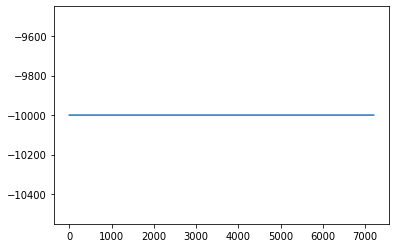

In [29]:
plt.plot(mag_tm[0])

In [ ]:
# smoothing
plt.plot(np.convolve(energies, np.ones((N**2,))/N**2, mode='valid'))

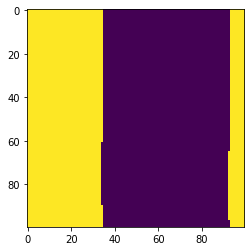

In [25]:
#grid = get_random_grid(50)
plt.imshow(grid[0,0])

## Use simple serial algorithm

In [54]:
J = 0.5
mu = 0

temps = np.linspace(0.05, 3, 100)
eneg_tm = []
mag_tm = []
for T in temps:
    beta = 1/T
    grid = ising.get_random_grid(N)
    
    # Thermalise    
    therm_sweeps = 200
    for ix in random_ix(N, steps=N**2*therm_sweeps):
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
    
    E = [ising.ising_energy(grid, J, mu)]
    M = [np.mean(grid)]
    print('measure t=',T)
    for ix in random_ix(N, steps=N**2*100):
        raise
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append(np.mean(grid))
        
    print('done measure')
    eneg_tm.append(E)
    mag_tm.append(M)

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

[ax.set_title(t) for ax, t in zip(sum(map(list, axs),[]),
                              ['Energy','Specific Heat', 'Magnetization', 'Susceptibility'])]

axs[0,0].plot(temps, list(map(np.mean, eneg_tm)))
axs[0,1].plot(temps, list(map(np.std, eneg_tm)))
axs[1,0].plot(temps, list(map(np.mean, mag_tm)))
axs[1,1].plot(temps, list(map(np.std, mag_tm)))
